In [26]:
import scvelo as scv
#import dynamo as dyn
import numpy as np
from anndata import AnnData
# import loompy
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
# from RKHS import SparseVFC
# from RKHS import Jacobian_rkhs_gaussian
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix

import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD

from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

from g2g_model_Fisher import CompleteKPartiteGraph,AttributedGraph,GraphDataset,Encoder,\
                            level_sets,train_test_split,reset_seeds

import seaborn as sns
from scipy.stats import gaussian_kde

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())

data_path = 'data/'
data_name = 'DG_bin'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
# data_name = 'zebrafish_dynamo_part'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
#adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
pca_dim = 50
[k_nei, K, L] = [20, 2, 10]

# new_para_name = 'PCA'
new_para_name = 'eigengene'
# new_para_name = 'hotspot'
# new_para_name = ''

# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'
method = ''

result_path = 'DTW_action_results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = result_path
cmap = plt.colormaps['Spectral']

import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

2.3.0
None
False
0


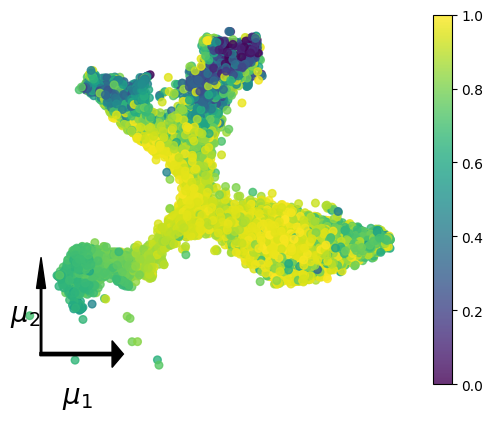

In [27]:
data_path='data/'
#data_name = 'BoneMarrow/human_cd34_bone_marrow.h5ad'
#data_name = 'EG_ab_dyn.h5ad'
data_name = '20DG_data.h5ad'
#data_name = 'processed bonemarrow.h5ad'
#data_name = 'lung.h5ad'
#data_name = 'DentateGyrus/DentateGyrus.loom'
adata0=scv.read(data_path+data_name, cache=True)

#model_name = 'EG_ab_dyn'
#model_name = 'processed bonemarrow'
#model_name = 'lung'
model_name = 'DentateGyrus'

subfolder = 'weighted'
result_path = 'results/'+model_name+'/'+subfolder+'/'+f'{new_para_name}_critical/'
import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径
    
k_nei = 20
# #-------data preprocessing
# while True:

#     #adata=adata0.copy()
#     scv.pp.neighbors(adata0, n_neighbors=k_nei)
#     scv.pp.moments(adata0, n_pcs=50, n_neighbors=k_nei)
#     zero_gene_num = np.sum(np.sum(adata0.layers['Ms'],axis=0) == 0)
#     print('zero_gene_num',zero_gene_num)
#     if zero_gene_num == 0:
#         lowvar_num = np.sum(np.var(adata0.layers['Ms'],0)<1e-1)
#         print('lowvar_num',lowvar_num)
#         if lowvar_num == 0:
#             break
#         else:
#             adata0 = adata0[:,(np.var(adata0.layers['Ms'],0)>1e-1)]
#     else:
#         adata0 = adata0[:,(np.sum(adata0.layers['Ms'],axis=0) != 0)]

# scv.pp.pca(adata0,n_comps=50)

# scv.tl.velocity(adata0)
# scv.tl.velocity_graph(adata0)
# scv.tl.velocity_pseudotime(adata0)

 ###读存储数据
K,L = 3,6
read_path = 'results/'+model_name+'/'+f'weighted/k_nei={k_nei}/'#+ f'k_nei={k_nei}/'
para = f'K={K} L={L}/'
para = ''
Xs = np.load(read_path+'X'+'.npy')
X_pca = np.load(read_path+'X_pca'+'.npy')
cell_nei = np.load(read_path+'cell_nei'+'.npy')
nei_w = np.load(read_path+'nei_w'+'.npy')
color_label = np.load(read_path+'color_label'+'.npy')
encoder = torch.load(read_path+para+'encoder'+'.pt')
Fisher_g = np.load(read_path+para+'Fisher_g'+'.npy')
crc_smooth = np.load(read_path+para+'crc_smooth'+'.npy')
crc_eu = np.load(read_path+para+'crc_eu'+'.npy')
k_nei=cell_nei.shape[1]
n = Xs.shape[0]

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def Fisher_dist_new(mu1, sigma1, mu2, sigma2):
    dmu = (mu1 - mu2) / np.sqrt(2)
    sigma_sum = sigma1 + sigma2
    sigma_diff = sigma1 - sigma2
    
    a = np.sqrt(dmu**2 + sigma_sum**2) + np.sqrt(dmu**2 + sigma_diff**2)
    b = np.sqrt(dmu**2 + sigma_sum**2) - np.sqrt(dmu**2 + sigma_diff**2)
    
    dF2 = 2 * np.sum(np.log(a / b)**2)
    return np.sqrt(dF2)

def wasserstein_distance_new(mu1, sigma1, mu2, sigma2):
    dmu = mu1 - mu2
    W_dist2 = np.sum(dmu**2 + sigma1**2 + sigma2**2 - 2 * np.sqrt(sigma2 * sigma1**2 * sigma2))
    return np.sqrt(W_dist2)

def Jacobian_nn_new(x0, encoder):
    x = torch.tensor(x0, requires_grad=True)
    
    # Compute the Jacobian for both outputs in the encoder
    def compute_jacobian(x):
        z = encoder(x)
        return torch.cat((z[0], z[1]))

    jacobian = torch.autograd.functional.jacobian(compute_jacobian, x)
    
    # Split the jacobian into two parts
    d = jacobian.shape[0] // 2
    pMu_pX = jacobian[:d]
    pSgm_pX = jacobian[d:]
    
    return pMu_pX.numpy(), pSgm_pX.numpy()


###############读数据
K,L = 3,6
read_path = 'results/'+model_name+'/'+'weighted/'+ f'k_nei={k_nei}/'
para = ''#f'K={K} L={L}/'
Xs = np.load(read_path+'X'+'.npy')
X_pca = np.load(read_path+'X_pca'+'.npy')
cell_nei = np.load(read_path+'cell_nei'+'.npy')
nei_w = np.load(read_path+'nei_w'+'.npy')
color_label = np.load(read_path+'color_label'+'.npy')
encoder = torch.load(read_path+para+'encoder'+'.pt')
Fisher_g = np.load(read_path+para+'Fisher_g'+'.npy')
crc_smooth = np.load(read_path+para+'crc_smooth'+'.npy')
crc_eu = np.load(read_path+para+'crc_eu'+'.npy')
cell_vpt=color_label
X=Xs

###读存储数据numpy版本导致clusters读取失败运行这段代码
np.load.__defaults__ =(None, True, True, 'ASCII')
clusters = np.load(read_path+'clusters'+'.npy')
clusters_PAGA = np.load(read_path+'clusters_PAGA'+'.npy')
gene_arr = np.load(read_path+para+'gene_arr'+'.npy')
np.load.__defaults__ =(None, False, True, 'ASCII')

###读存储数据
X_plt = np.load(read_path+'X_plt'+'.npy')
Y_plt = np.load(read_path+'Y_plt'+'.npy')
##坐标 和 伪时间图

X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min+5*wid
Y_ori = Y_min+5*wid

plt.scatter(X_plt,Y_plt,s=30,alpha=0.8,c=color_label,cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.arrow(X_ori-wid/2,Y_ori,X_len,0,width=wid*1.5,color='black',head_width=12*wid,head_length=5*wid)
plt.arrow(X_ori,Y_ori-wid/2,0,Y_len,width=wid*2/3,color='black',head_width=4*wid,head_length=14*wid)

plt.text(X_ori+X_len/2,Y_ori-wid*22,'$\mu_1$',fontsize=20,ha='center',weight='bold')
plt.text(X_ori-wid*7,Y_ori+Y_len/2,'$\mu_2$',fontsize=20,ha='center',weight='bold')

# plt.savefig(result_path+model_name+'_mu.png',dpi=600,bbox_inches='tight')
plt.show()

In [28]:
#######要跑
adata=adata0.copy()
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
velo_pca = velo_g@adata.varm['PCs']
#latent_z = np.hstack((mu_learned,sigma_learned))

In [29]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()
latent_z = np.hstack((mu_learned,sigma_learned))

## coordinate transformation

In [30]:
import hotspot

In [31]:
#------use a simple neural network to study dmu/dt and dsigma/dt
def new_para(X,latent_z):
    np.random.seed(42)
    X = X.astype(np.float32)
    x_in = torch.tensor(X)
    pca_dim = x_in.shape[1]
    model = nn.Sequential(
        nn.Linear(pca_dim, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,2*L),
    )

    # Define your loss function and optimizer
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    x_out=torch.tensor(latent_z.astype(np.float32))
    # Train the model
    for epoch in range(200):  # number of epochs
        # Forward pass
        output = model(x_in)
        loss = loss_fn(output,x_out) 
    #     if epoch% 10 == 9:
    #         print(epoch,loss)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pZ_pX = np.zeros([X.shape[0], L*2, X.shape[1]])

    # Compute the gradients
    for i in range(X.shape[0]):
        x0=torch.tensor(X[i,:],requires_grad=True)
        z=model(x0)
        for j in range(2*L):
            x0.grad = None       
            z[j].backward(retain_graph=True)
            pZ_pX[i,j,:] = x0.grad.detach()
            

    return model,pZ_pX[:,:L,:],pZ_pX[:,L:,:]

In [32]:
def eigen_gene(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        pca=PCA(n_components=3).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_.T)
    #        eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

def eigen_gene_hs(X_re,T_re):#return the weights of each gene in correponding eigen gene
    eigen_X_w = []
    pc = []
    for i in np.unique(T_re):
        if i < 0:
            continue
        pca=PCA(n_components=2).fit(X_re[:,T_re==i])
        print(pca.explained_variance_ratio_)
        pc.append(pca.transform(X_re[:,T_re==i]))
        eigen_X_w.append(pca.components_[0,:])
#         eigen_gene_size.append(np.where(T_re==i)[0].shape[0])
    return np.array(pc),eigen_X_w

def compute_x_eigen(X):
    global eigen_X,eigen_X_w
    X_corr=np.corrcoef(X, rowvar=False)
    plt.imshow(X_corr)
    plt.colorbar()
    plt.show()

    Z=linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
    dg=dendrogram(Z)
    X_re= X[:,dg['leaves']]#X_re reorder X by clustering

    X_corr_re=np.corrcoef(X_re, rowvar=False)
    plt.show()

    td = 0.95
    T = fcluster(Z, t=td, criterion='distance')
    # T=fcluster(Z, t=td, criterion='maxclust')
    T_re = T[dg['leaves']]

    plt.imshow(X_corr_re, aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest',origin='lower')
    plt.show()

    X_corr_label = np.zeros(X_corr_re.shape)
    for i in range(X_corr_re.shape[0]):
        label_ind = np.where(T_re==T_re[i])[0]
        X_corr_label[i,label_ind] = 1

    plt.imshow(X_corr_label, aspect='auto', cmap=plt.cm.gray, interpolation='nearest',origin='lower')
    plt.colorbar()
    plt.show()


    eigen_X,eigen_X_w=eigen_gene(X_re,T_re)
    eigen_dim=len(np.unique(T_re))
    n_eigen = 1
    cell_eigen_X = eigen_X[0,:,:n_eigen]
    for i in range(eigen_dim-1):
        cell_eigen_X = np.hstack((cell_eigen_X,eigen_X[i+1,:,:n_eigen]))
    return cell_eigen_X

def compute_x_hs(X):
    global hs_X, hs_X_w
    # Create the Hotspot object and the neighborhood graph
    # hotspot works a lot faster with a csc matrix!
    hs = hotspot.Hotspot(
        adata, 
        model='danb',
        distances_obsp_key = 'distances'
    )

    hs.create_knn_graph(
        weighted_graph=False, n_neighbors=k_nei,
    )

    hs_results = hs.compute_autocorrelations(jobs=1)

    # Select the genes with significant lineage autocorrelation
    hs_genes = hs_results.loc[hs_results.FDR < 0.1].sort_values('Z', ascending=False).head(1000).index

    # Compute pair-wise local correlations between these genes
    lcz = hs.compute_local_correlations(hs_genes, jobs=1)

    modules = hs.create_modules(
        min_gene_threshold=10, core_only=True, fdr_threshold=0.1
    )

    modules.value_counts()
    # np.save(result_path+'modules', modules.values)
    # np.save(result_path+'hs_genes', hs_genes)

    adata_hs = adata[:,hs_genes] # 只用hotspot有效的gene
    T_hs = np.array(hs.modules.tolist()) # 记录所有hs gene的module

    scaler = StandardScaler()
    X_hs = scaler.fit_transform(adata_hs.layers['Ms'])
    hs_X, hs_X_w = eigen_gene_hs(X_hs,T_hs)
    hs_dim=len(hs_X_w)
    print(X_hs.shape,hs_X.shape,hs_X_w,hs_dim)
    cell_hs_X=np.zeros((X_hs.shape[0],hs_dim))
    for j in range(X_hs.shape[0]):
        for k in range(len(hs_X_w)):
            cell_hs_X[j,k]=np.dot(hs_X_w[k],X_hs[j,T_hs==k+1])


    return cell_hs_X

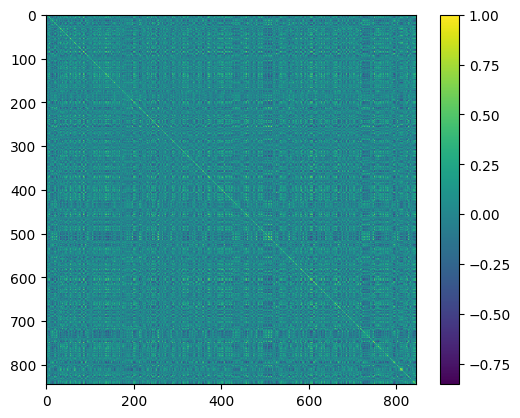

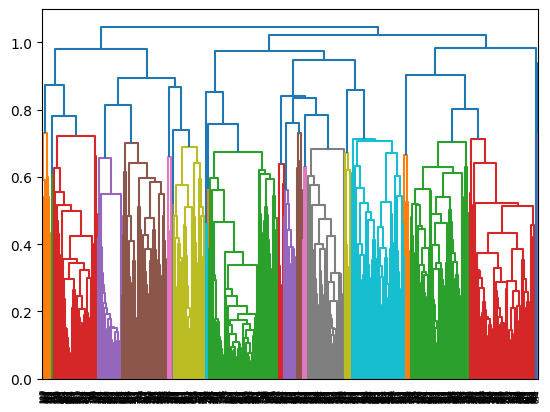

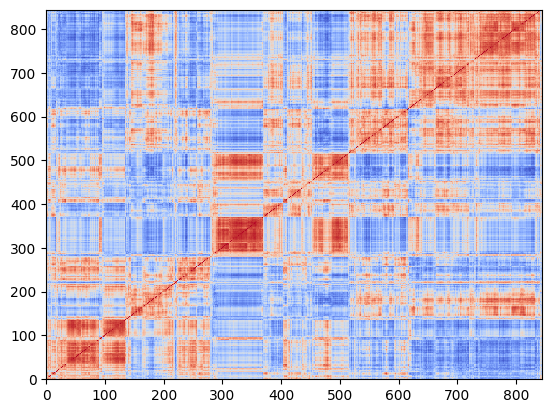

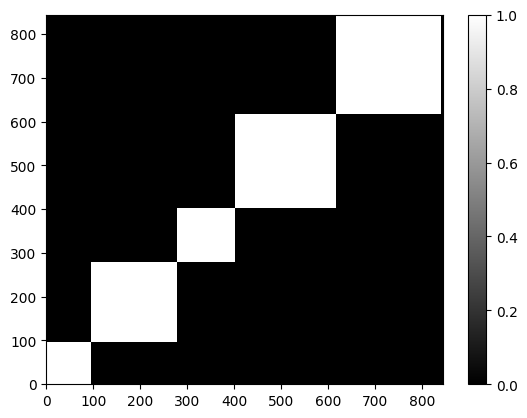

[0.6249977  0.30152166 0.01997065]
[0.5633189  0.17219374 0.10740758]
[0.8814889  0.07412795 0.01775031]
[0.7674953  0.1113115  0.04026997]
[0.6525764  0.11773635 0.05034393]
[0.41713455 0.24436341 0.18871762]


In [33]:
if new_para_name == 'PCA':
    X = X_pca
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)
if new_para_name == 'eigengene':
    X = compute_x_eigen(X)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)
if new_para_name == 'hotspot':
    X = compute_x_hs(X)
    encoder,pMu_pX,pSgm_pX = new_para(X,latent_z)

In [34]:

cl_name = np.unique(clusters)
palette = sns.color_palette("RdBu_r",n_colors=cl_name.shape[0])
# palette = sns.color_palette(n_colors=cl_name.shape[0])
cln = np.array(clusters)
cl_vpt = np.zeros(cl_name.shape[0])
for i in range(cl_name.shape[0]):
    if data_name=='DG_bin':
        cl_vpt[i] = np.mean(cell_vpt[cln==cl_name[i]])
    else:
        cl_vpt[i] = np.mean(cell_vpt[cln==cl_name[i]])
cl_vpt_ind = np.argsort(cl_vpt)
cl_name_vpt = cl_name[cl_vpt_ind]

cln_vpt_ind = np.zeros(cln.shape[0],dtype=int)
clx = np.zeros(cln.shape[0])
clc = np.array([palette[0]]*cln.shape[0])
cl_ind = np.zeros(cl_name.shape[0])
i_ind = 0
for i in range(cl_name.shape[0]):
    cli_ind = np.argwhere(cln==cl_name_vpt[i])[:,0]
    ni = cli_ind.shape[0]
    cln_vpt_ind[i_ind:i_ind+ni] = cli_ind
    clx[cli_ind] = i
    clc[cli_ind] = palette[i]
    cl_ind[i] = i_ind+ni/2
    i_ind += ni
cln_vpt = cln[cln_vpt_ind]

In [35]:
from utils import *
velo = np.load(read_path+'velocity'+'.npy')

In [36]:
if new_para_name == '':
    pMu_pX = np.zeros([X.shape[0],L,X.shape[1]])
    pSgm_pX = np.zeros([X.shape[0],L,X.shape[1]])
    for i in range(X.shape[0]):
        pMu_pX[i],pSgm_pX[i] = Jacobian_nn(X[i],L,encoder)

# pMu_pX = np.zeros([X.shape[0],L,X.shape[1]])
# pSgm_pX = np.zeros([X.shape[0],L,X.shape[1]])
# for i in range(X.shape[0]):
#     pMu_pX[i],pSgm_pX[i] = Jacobian_nn(X[i],L,encoder)
#     #pMu_pX[i],pSgm_pX[i] = Jacobian_nn_new(X[i],L,encoder)
# mu_velo = np.array([pMu_pX[i]@velo[i] for i in range(X.shape[0])])
# sgm_velo = np.array([pSgm_pX[i]@velo[i] for i in range(X.shape[0])])
# zv2 = np.zeros(X.shape[0])
# for i in range(X.shape[0]):
#     for j in range(L):
#         zv2[i] += Fisher_g[i,j,j]*mu_velo[i,j]**2 + Fisher_g[i,L+j,L+j]*sgm_velo[i,j]**2
# zv1 = np.sqrt(zv2)
# zv1_smooth = smooth_func(zv1)

In [37]:
# #-------------transcription factors analysis
# df = pd.read_csv(data_path+'gene lists/mouse_TF_list.csv')
# TF = df['Symbol'].values
# adata=adata0.copy()
# for ti in range(len(TF)):
#     TF[ti] = TF[ti].upper()
# gene_list = np.array([x.upper() for x in adata.var.index.values])
# tf_inds = np.where(np.in1d(gene_list,TF))[0]
# non_tf_inds = np.where(~np.in1d(gene_list,TF))[0]
# tf_gene = adata.var.index.values[tf_inds]
# print(len(tf_inds))

In [38]:
###gene FI and stiff gene
stiffnum = np.zeros(X.shape[0])##number of stiffgene |(n,1)
# tf_stiffnum = np.zeros(X.shape[0])
pZ_pX = np.zeros([X.shape[0], L*2, X.shape[1]])
diagFIgene = np.zeros((X.shape[0],X.shape[1])) ##FI of gene |(n,m)
Eigenvec = np.zeros((X.shape[0],X.shape[1]))   ##1st eigenvec for each cell |(n,m)
Eigenval = []  ##前2特征值 | (n,2)
for i in range(X.shape[0]):
    pZ_pX[i] = np.vstack((pMu_pX[i],pSgm_pX[i]))
    FIgene_i = pZ_pX[i].T@Fisher_g[i]@pZ_pX[i]
    Eigenval.append([np.linalg.eigh(FIgene_i)[0][-1],np.linalg.eigh(FIgene_i)[0][-2]])
    Eigenvec[i] = np.linalg.eigh(FIgene_i)[1][:,-1]
    diagFIgene[i] = np.diag(FIgene_i)
    FI_max = np.array([np.argmax(FIgene_i[j]) for j in range(X.shape[1])])
    # tf_max = np.array([np.argmax(FIgene_i[tf_inds][:,tf_inds][j]) for j in range(len(tf_inds))])
    stiffnum[i] = len(np.unique(list(FI_max)))
    # tf_stiffnum[i] = len(np.unique(list(tf_max)))
Eigenval = np.array(Eigenval)

In [39]:
print('平均前二特征值差距倍数：',np.mean(Eigenval[:,0]/Eigenval[:,1]))
print('最大前二特征值差距倍数：',np.max(Eigenval[:,0]/Eigenval[:,1]))
print('最小前二特征值差距倍数：',np.min(Eigenval[:,0]/Eigenval[:,1]))
print('Eigenvec.shape',Eigenvec.shape)

平均前二特征值差距倍数： 31.500568119720153
最大前二特征值差距倍数： 145.71557945115794
最小前二特征值差距倍数： 3.7165190756308095
Eigenvec.shape (14366, 6)


In [40]:
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)

Eigen gene direction

In [41]:
categories = np.unique(clusters)
eigenvec={}
for i in categories:
    eigenvec[i] = Eigenvec[clusters==i]

In [42]:
def PLT_box(clusters,matrix,save_path,ylabel,title_name='violin',xlabel='cell_type',cell_sort=None):
    categories = list(set(clusters[np.argsort(color_label)]))
    if cell_nei is None:
        None
    else:
        categories.sort(key = list(clusters[np.argsort(cell_sort)]).index)
    eigenvalues = {}
    for i in categories:
        eigenvalues[i] = matrix[clusters==i]
    plt.figure()
    #plt.violinplot([eigenvalues[i].reshape(eigenvalues[i].shape[0]*eigenvalues[i].shape[1]) for i in list(eigenvalues)], showmeans=True, showmedians=True)
    for j in range(matrix.shape[1]):
        plt.boxplot([eigenvalues[i][:,j] for i in list(eigenvalues)])
    # 设置x轴的标签
    #plt.xticks([1, 2, 3], ['Group A', 'Group B', 'Group C'])
    plt.xticks(range(1,len(categories)+1),categories)
    if np.sum([len(i) for i in categories])>50:
        plt.xticks(rotation=40)
    # 添加标题和标签
    plt.title(title_name,fontsize=16,weight='bold')
    plt.xlabel(xlabel,fontsize=14,weight='bold')
    plt.ylabel(ylabel,fontsize=14,weight='bold')
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
    plt.show()

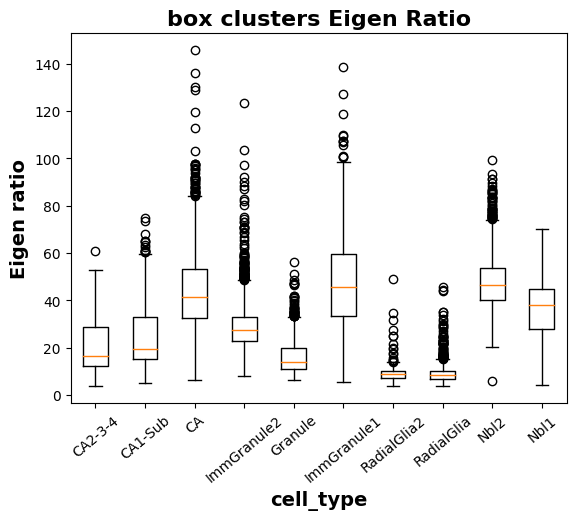

In [43]:
##画图，前2特征值比值图
PLT_box(clusters,(Eigenval[:,0]/Eigenval[:,1]).reshape((X.shape[0],1)),save_path=result_path+f'box Eigen Ratio {new_para_name}'+'.png',
           ylabel='Eigen ratio',title_name='box clusters Eigen Ratio',cell_sort=cell_vpt)

In [44]:
for i in categories:
    print(f'{i}平均前二特征值差距倍数：',np.mean((Eigenval[:,0]/Eigenval[:,1])[clusters==i]))
    print(f'{i}最大前二特征值差距倍数：',np.max((Eigenval[:,0]/Eigenval[:,1])[clusters==i]))
    print(f'{i}最小前二特征值差距倍数：',np.min((Eigenval[:,0]/Eigenval[:,1])[clusters==i]))

CA平均前二特征值差距倍数： 43.235708934480876
CA最大前二特征值差距倍数： 145.71557945115794
CA最小前二特征值差距倍数： 6.194966256057108
CA1-Sub平均前二特征值差距倍数： 24.538575129456035
CA1-Sub最大前二特征值差距倍数： 75.00391796504924
CA1-Sub最小前二特征值差距倍数： 5.2146548860118145
CA2-3-4平均前二特征值差距倍数： 20.148648492516866
CA2-3-4最大前二特征值差距倍数： 60.98935548961187
CA2-3-4最小前二特征值差距倍数： 3.7165190756308095
Granule平均前二特征值差距倍数： 16.432554644961645
Granule最大前二特征值差距倍数： 56.35477334499016
Granule最小前二特征值差距倍数： 6.334710132884278
ImmGranule1平均前二特征值差距倍数： 47.6597879920125
ImmGranule1最大前二特征值差距倍数： 138.61187298112728
ImmGranule1最小前二特征值差距倍数： 5.574345291930917
ImmGranule2平均前二特征值差距倍数： 29.255019301179
ImmGranule2最大前二特征值差距倍数： 123.42652789035762
ImmGranule2最小前二特征值差距倍数： 8.160878717125525
Nbl1平均前二特征值差距倍数： 35.392016973013774
Nbl1最大前二特征值差距倍数： 70.16914998171512
Nbl1最小前二特征值差距倍数： 4.137175530701624
Nbl2平均前二特征值差距倍数： 48.28475077547428
Nbl2最大前二特征值差距倍数： 99.29859021883458
Nbl2最小前二特征值差距倍数： 6.0187962941661
RadialGlia平均前二特征值差距倍数： 9.449768995135368
RadialGlia最大前二特征值差距倍数： 45.707782535263256
RadialGli

In [45]:
for i in categories:
    print(i,len(Eigenvec[clusters==i]))

CA 2298
CA1-Sub 1664
CA2-3-4 2129
Granule 863
ImmGranule1 2460
ImmGranule2 2099
Nbl1 419
Nbl2 1003
RadialGlia 1043
RadialGlia2 388


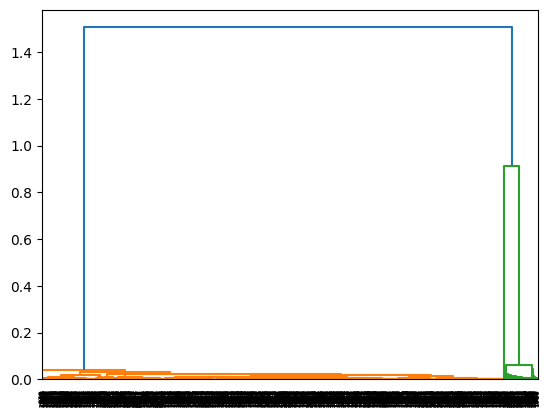

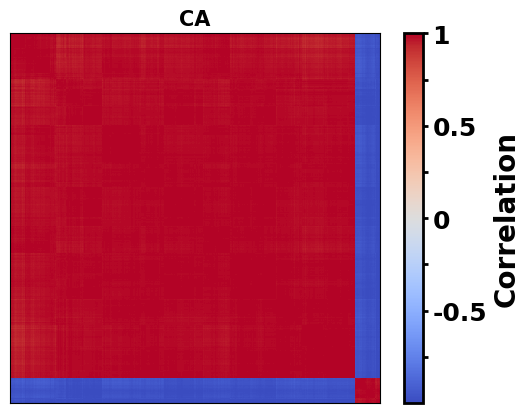

[1 1 1 ... 2 2 1]


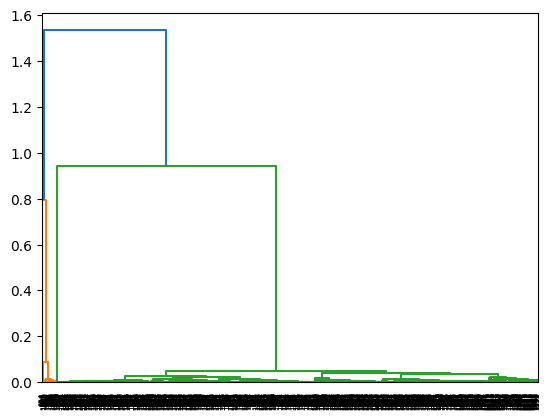

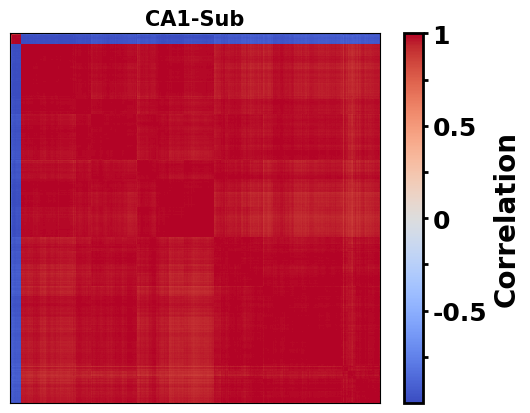

[2 2 2 ... 2 2 2]


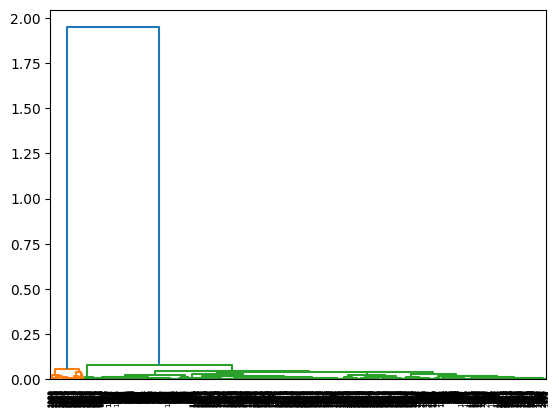

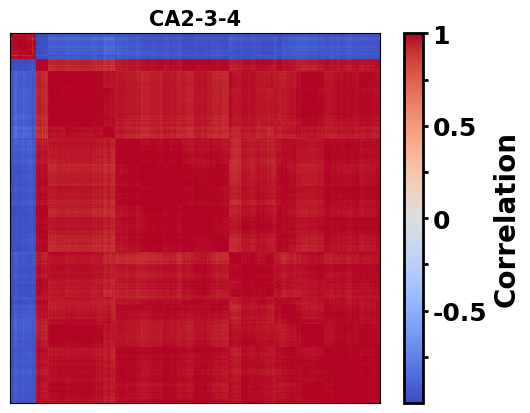

[2 2 2 ... 2 2 1]


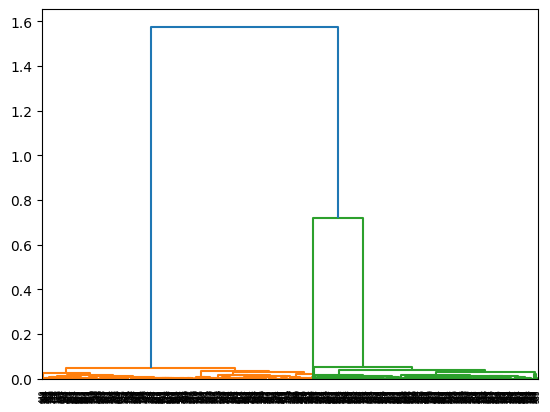

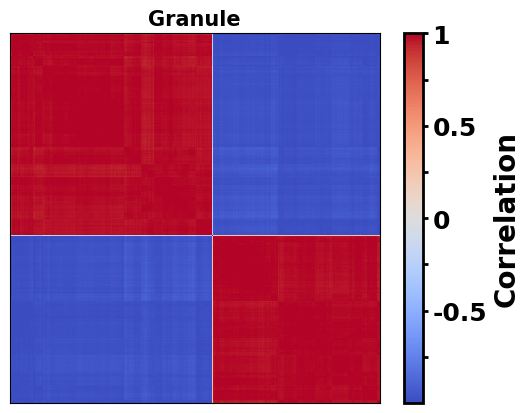

[1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 2 1 2 2 1 1 1 1 2
 1 1 2 1 1 2 1 1 2 1 2 2 2 1 2 2 1 2 2 1 1 2 2 2 2 1 1 1 1 2 1 1 1 2 1 1 1
 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1
 1 2 1 2 2 1 1 2 1 1 1 2 1 1 1 1 2 2 2 1 1 1 2 2 1 2 2 2 2 2 1 2 1 1 2 2 2
 2 1 2 2 1 1 2 2 2 2 1 2 1 1 2 2 1 1 1 1 1 2 2 2 1 2 2 2 2 2 1 2 1 1 1 2 1
 2 2 1 1 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1 1 1 1 1 1 2 2 1 2
 1 1 2 1 1 1 2 2 1 1 2 1 1 2 2 1 2 2 1 2 1 2 2 2 1 1 2 1 1 1 1 1 2 1 2 1 2
 2 2 1 1 2 1 2 2 1 1 1 2 1 2 2 1 2 1 1 2 1 2 1 1 1 2 1 2 1 2 1 1 2 2 2 1 2
 1 1 2 1 2 1 2 2 2 2 1 1 2 2 1 1 1 1 1 1 1 2 1 2 1 2 1 1 2 1 1 2 1 2 1 1 1
 2 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 2 2 2 1 1 1 2 2 1 1 1 1 1 2 1 2 2 2 1 2 2
 2 1 2 1 1 2 2 2 1 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 1 2 2 2 1 1 1 1 1 2 2 2 2
 1 1 1 2 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 2 1 1 1 2 1 1 2 1 2 2 1 2 1 2
 1 2 2 2 1 2 2 2 1 2 2 2 2 2 1 1 2 2 1 1 2 1 1 2 1 1 2 1 1 1 1 1 2 1 1 2 1
 1 1 1 1 1 2 2 2 2 2 1 1 

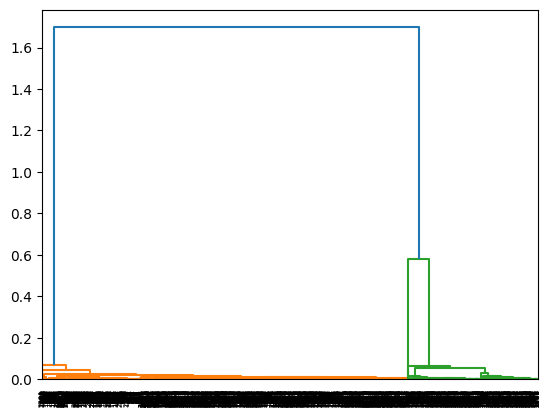

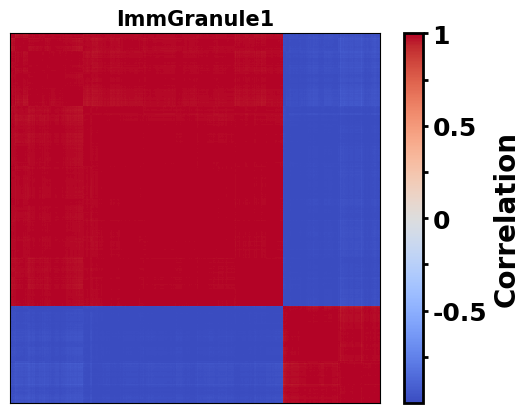

[1 1 1 ... 1 2 2]


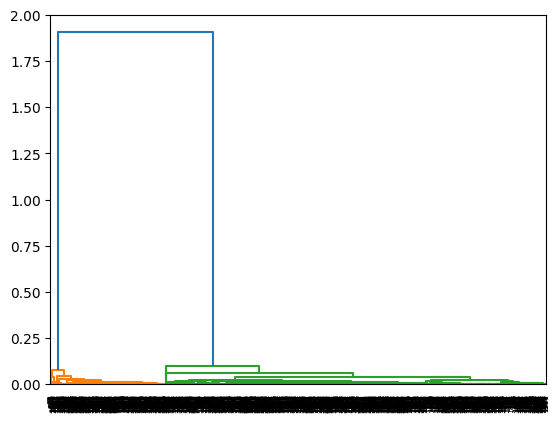

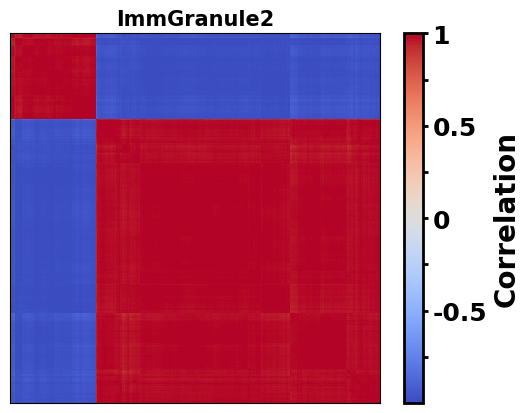

[2 2 2 ... 1 2 2]


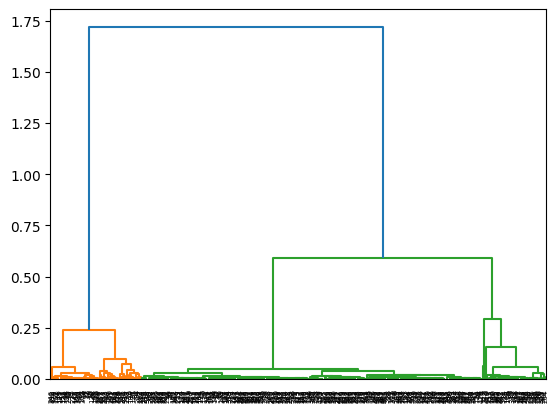

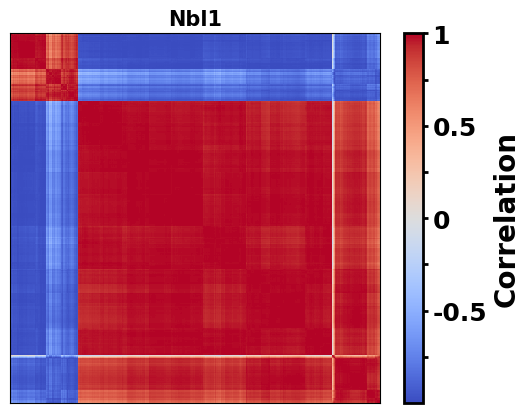

[2 2 1 2 2 2 1 1 2 2 2 1 2 2 2 1 1 2 2 2 2 1 1 1 2 2 2 1 1 2 2 1 2 2 2 1 1
 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2
 1 1 2 1 2 1 2 2 1 2 1 2 2 2 2 1 2 2 2 1 1 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2
 2 2 1 2 2 2 2 2 2 1 1 1 2 2 1 1 2 1 2 2 2 2 2 2 2 2 2 2 1 2 1 2 1 2 2 2 1
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 1 2 1 1 2 1
 2 1 2 2 2 2 1 2 2 2 1 2 2 1 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1
 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2
 1 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]


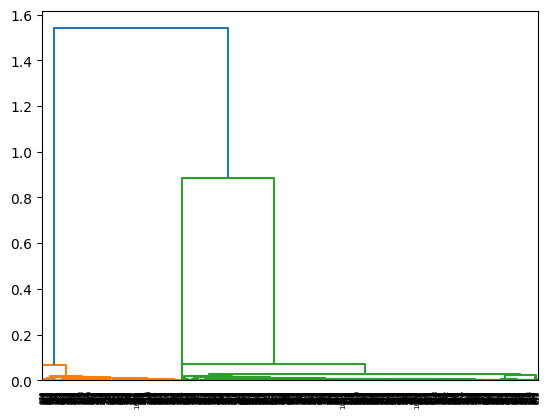

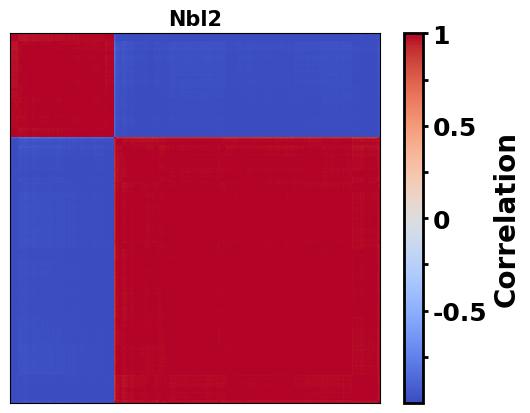

[2 1 2 ... 2 2 1]


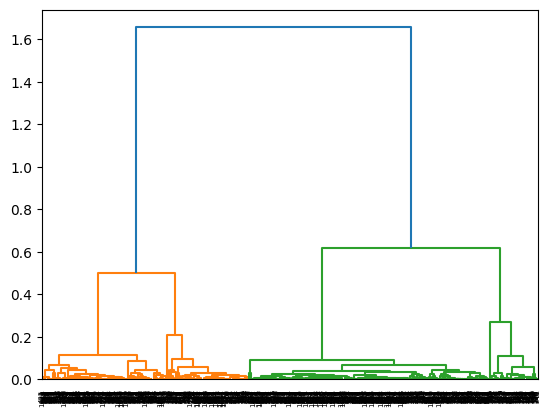

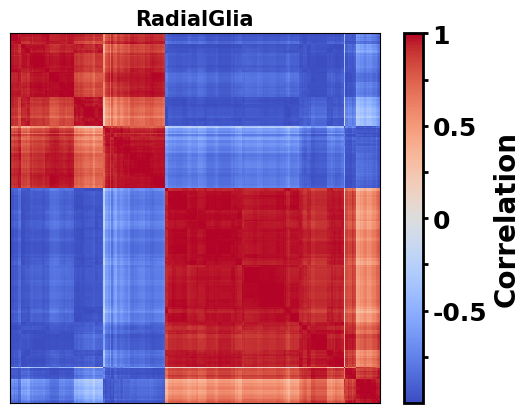

[1 2 1 ... 1 1 2]


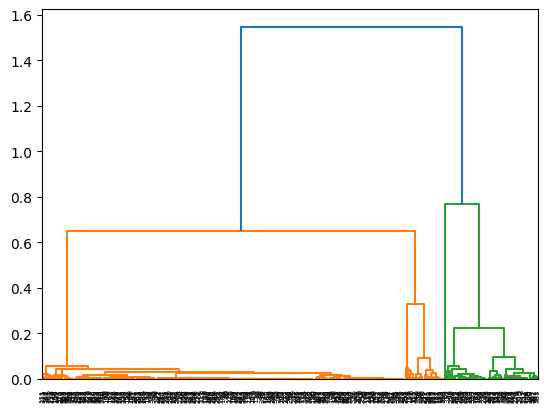

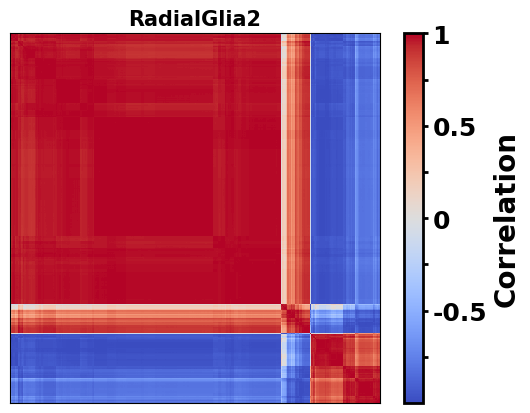

[1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2
 1 1 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 1 1 1 1 2
 2 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 2 2 1
 1 1 2 2 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2
 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 2 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 2 1 1 1 2 1 1 1 1 1 2 1 1
 1 1 1 1 2 1 1 2 2 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1
 1 1 2 1 1 1 1 2 1 1 1 1 2 2 1 2 1 2]


In [46]:
###Before optimize the cosdistance

for i in range(len(categories)):
    cl_cat = categories[i]
    vec_corr = eigenvec[cl_cat]@eigenvec[cl_cat].T
    
    Z=linkage((1-vec_corr)[np.triu_indices(vec_corr.shape[0],k=1)],method='weighted')#method='weighted')
    dg=dendrogram(Z)
    #X_re= X[:,dg['leaves']]#X_re reorder X by clustering
    plt.show()
    
    vec_corr_re = vec_corr[dg['leaves'],:][:,dg['leaves']]
    plt.imshow(vec_corr_re, aspect='equal', cmap=plt.cm.coolwarm, interpolation='nearest')
    plt.title(categories[i],fontsize=15,weight='bold')
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(width=2)  # 设置刻度线宽度
    cb.outline.set_linewidth(2)  # 设置 colorbar 边框宽度
# 设置 colorbar 刻度字体和加粗
    for tick in cb.ax.get_yticklabels():
        tick.set_fontsize(18)  # 设置刻度标签字体大小
        tick.set_weight('bold')  # 设置刻度标签加粗
    # 设置 colorbar 的标题
    cb.set_ticklabels(['-1','', '-0.5', '','0','', '0.5','', '1'])  # 设置刻度标签
    cb.set_label('Correlation', fontsize=20, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(result_path+f'Corr of {categories[i]}.png')
    plt.show()

    # xcos = np.linspace(0,1,100)
    # plt.plot(xcos,gaussian_kde(vec_corr.flatten())(xcos))
    # plt.title(categories[i],fontsize=15,weight='bold')
    # plt.show()
    
    T = fcluster(Z, t=0.9, criterion='distance')
    print(T)

In [47]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
def GRBopt(Eigenvec):
    n = len(Eigenvec)
    np.random.seed(42)
    X = Eigenvec@Eigenvec.T
    # Create model
    m = gp.Model("binary_quadratic")

    # Create binary variables (will be transformed to {-1,1})
    b = m.addVars(n, vtype=GRB.BINARY, name="b")

    # Set objective: min sum_{i,j} c_i c_j x_{ij}
    # where c_i = 2b_i - 1 transforms binary variables to {-1,1}
    obj = gp.QuadExpr()
    for i in range(n):
        for j in range(n):
            # Expand (2b_i - 1)(2b_j - 1)x_{ij}
            obj += -4 * X[i,j] * b[i] * b[j]  # quadratic term
            obj += 2 * X[i,j] * b[i]        # linear terms
            obj += 2 * X[i,j] * b[j]
            obj += -X[i,j]                    # constant term

    m.setObjective(obj, GRB.MINIMIZE)

    m.params.TimeLimit = 50*60

    # Optimize
    m.optimize()

    # Extract solution
    if m.status == GRB.OPTIMAL:
        # Convert binary solution back to {-1,1}
        c = [2 * b[i].x - 1 for i in range(n)]
        print("Optimal solution found:")
        print("c =", c)
        print("Objective value =", m.objVal)
        return c
    else:
        print("No optimal solution found")


In [48]:
eigenvec={}
for i in categories:
    c = GRBopt(Eigenvec[clusters == i])
    eigenvec[i] = np.diag(c)@Eigenvec[clusters==i]

Set parameter TimeLimit to value 3000
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 9600X 6-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  3000

Optimize a model with 0 rows, 2298 columns and 0 nonzeros
Model fingerprint: 0x50d47c91
Model has 2641551 quadratic objective terms
Variable types: 0 continuous, 2298 integer (2298 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+02, 8e+03]
  QObjective range [2e-05, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -3907589.599
Found heuristic solution: objective -5198026.722
Presolve time: 3.78s
Presolved: 0 rows, 2298 columns, 0 nonzeros
Presolved model has 2639253 quadratic objective terms
Variable types: 0 continuous, 2298 integer (2298 binary)

Root simplex lo

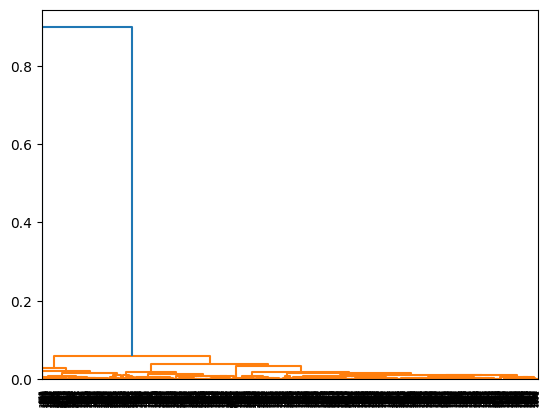

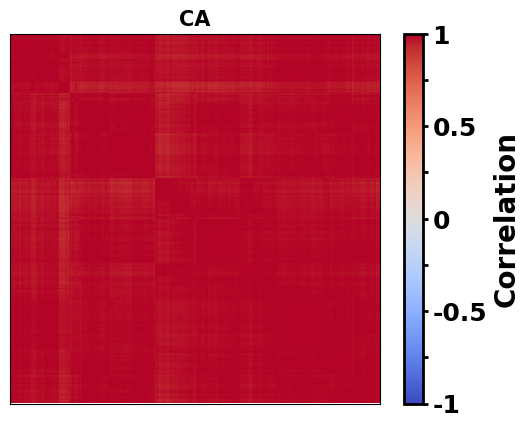

[1 1 1 ... 1 1 1]


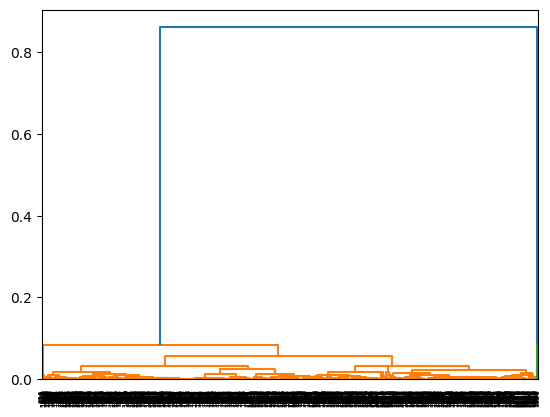

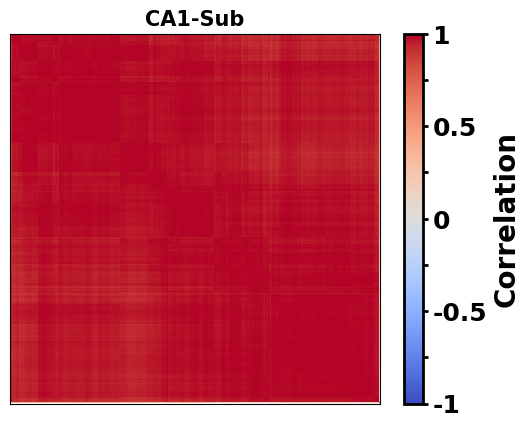

[1 1 1 ... 1 1 1]


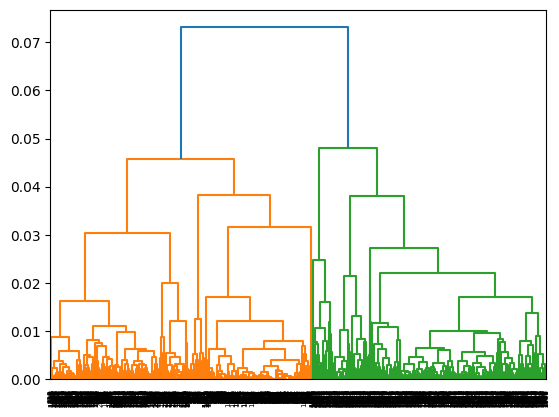

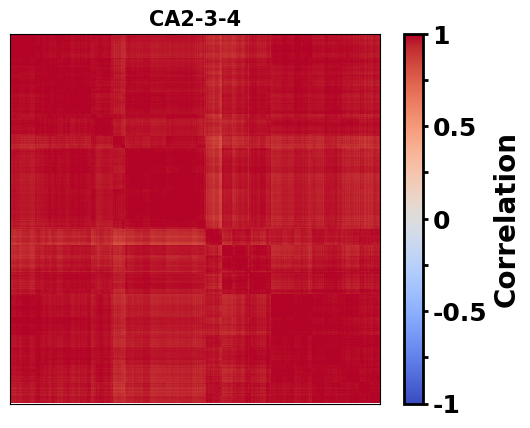

[1 1 1 ... 1 1 1]


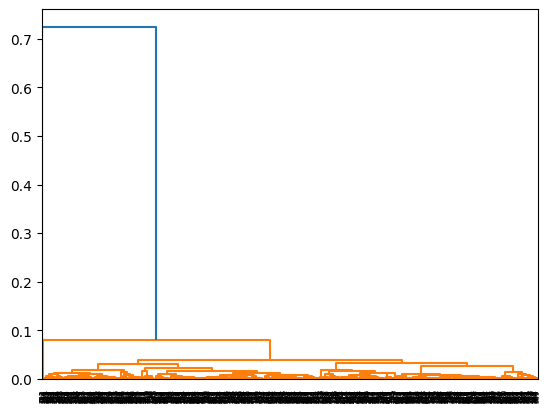

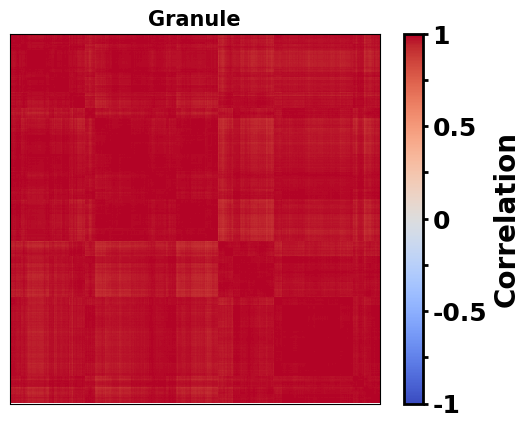

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

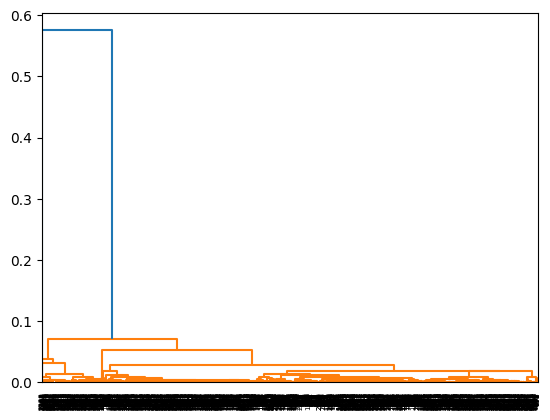

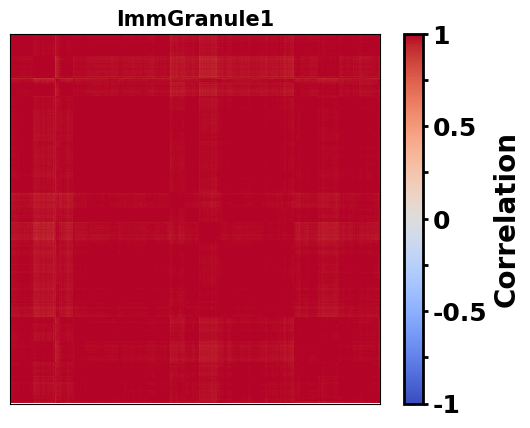

[1 1 1 ... 1 1 1]


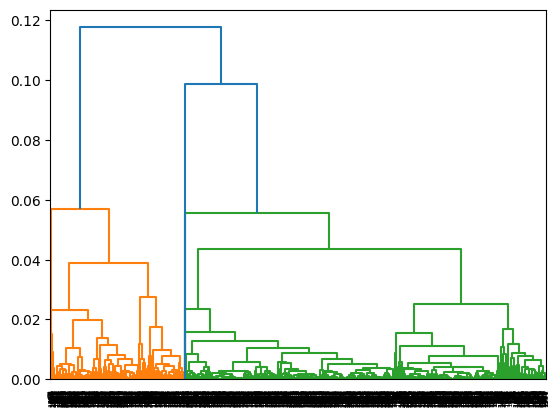

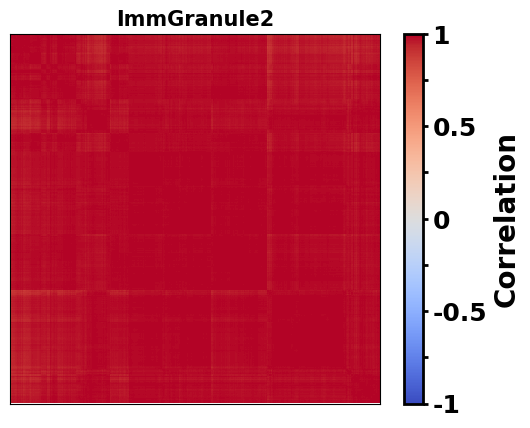

[2 2 2 ... 1 2 2]


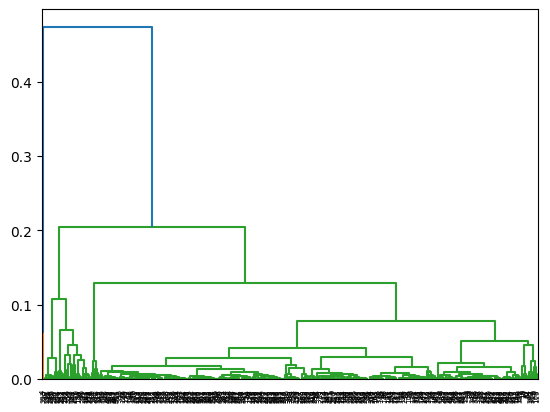

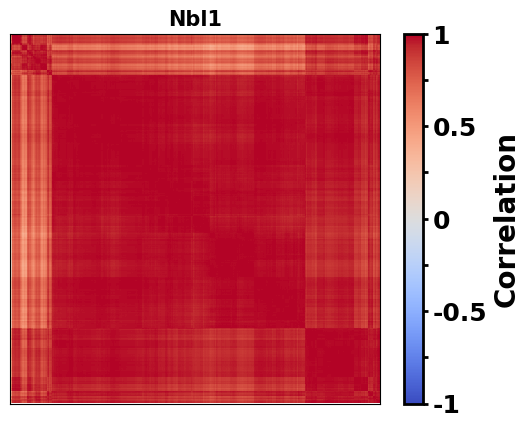

[5 5 5 5 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 3 5 5 5 5 5
 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 2 5 5 3 5 5 5
 5 5 5 5 5 3 2 5 5 5 5 2 5 5 5 4 5 2 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 3 5 5 3
 5 3 5 5 5 5 3 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 2 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 3 5 5 2 5 3
 5 5 5 5 5 2 5 5 2 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 5 2 5 5 5 5 5 2 5 5 5 3
 2 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 1 5 5 5 5 5 5 5 5 5
 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 3 5 5 4 5 5 5 5 5 3 5 3 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 3 5 5 5 5 5 5 5 2 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 3 3 5 5
 5 5 5 5 5 5 5 5 5 5 5 5]


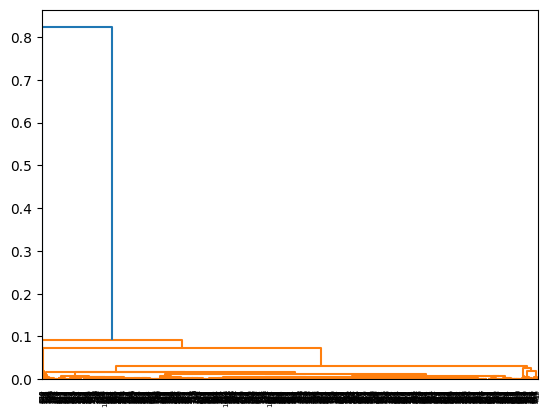

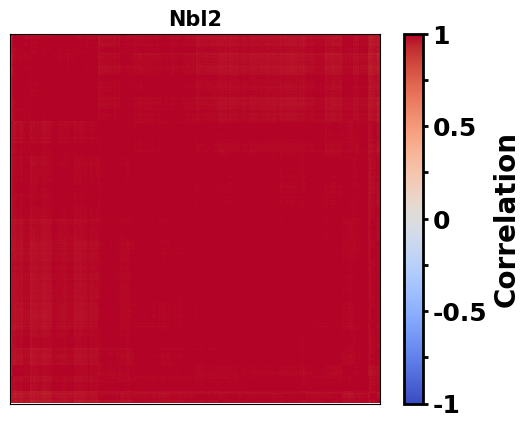

[1 1 1 ... 1 1 1]


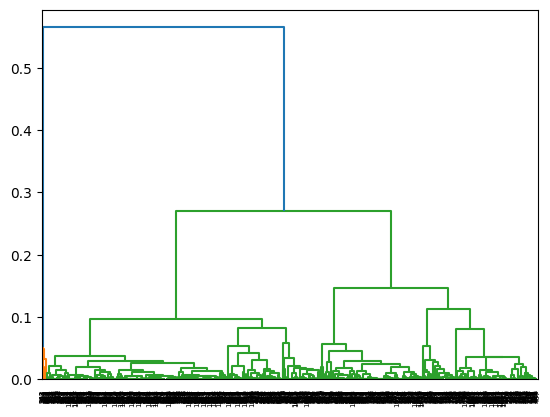

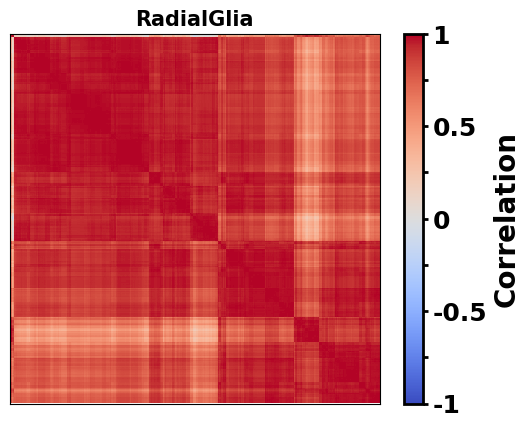

[2 3 2 ... 2 5 2]


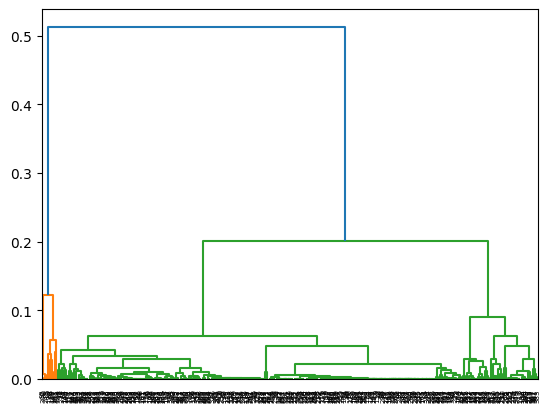

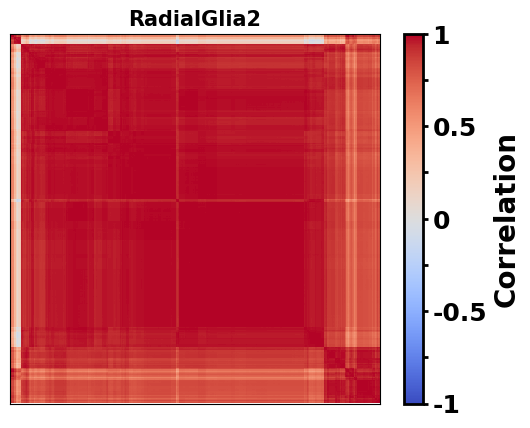

[3 3 3 4 4 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 4 3 3 3 3 3 3 4 3 3 3 4 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3
 3 3 3 3 3 3 4 3 3 4 2 3 3 3 3 3 1 3 3 3 3 1 3 3 3 3 4 3 3 3 4 3 3 3 3 3 3
 3 2 3 3 4 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 4 3 3 3 4 3 4
 3 3 3 3 4 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4 3 3 3 3 3 3 3 3
 4 3 3 3 3 3 3 3 3 3 4 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 4 3 3 4 4
 4 3 4 3 3 3 4 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 1 3 3 4 4 3 3 3 3 3 3
 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 4 4 3 3 4 3 3 3 3 3 3 3 3 4 3 3 3 3 2 3 3
 3 3 3 3 3 2 3 3 4 3 3 1 3 3 3 4 4 4 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3
 3 3 4 3 3 3 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 4 3 3
 3 3 4 3 3 3 3 4 3 3 3 3 4 4 3 4 3 4]


In [111]:
###After optimize the cosdistance. cluster threshold is t
from matplotlib.colors import Normalize
t = 1 - 1.8/2#threshold
TT = {}
for i in range(len(categories)):
    cl_cat = categories[i]
    vec_corr = eigenvec[cl_cat]@eigenvec[cl_cat].T
    
    Z=linkage((1-vec_corr)[np.triu_indices(vec_corr.shape[0],k=1)],method='weighted')#method='weighted')
    dg=dendrogram(Z)
    #X_re= X[:,dg['leaves']]#X_re reorder X by clustering
    plt.show()
    
    vec_corr_re = vec_corr[dg['leaves'],:][:,dg['leaves']]
    plt.imshow(vec_corr_re, aspect='equal', cmap=plt.cm.coolwarm, interpolation='nearest',norm=Normalize(-1,1))
    plt.title(categories[i],fontsize=15,weight='bold')
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    cb.ax.tick_params(width=2)  # 设置刻度线宽度
    cb.outline.set_linewidth(2)  # 设置 colorbar 边框宽度
# 设置 colorbar 刻度字体和加粗
    for tick in cb.ax.get_yticklabels():
        tick.set_fontsize(18)  # 设置刻度标签字体大小
        tick.set_weight('bold')  # 设置刻度标签加粗
    # 设置 colorbar 的标题
    cb.set_ticklabels(['-1','', '-0.5', '','0','', '0.5','', '1'])  # 设置刻度标签
    cb.set_label('Correlation', fontsize=20, fontweight='bold')
    plt.xticks([])
    plt.yticks([])
    plt.savefig(result_path+f'Corr_new of {categories[i]}.png')
    plt.show()

    # xcos = np.linspace(0,1,100)
    # plt.plot(xcos,gaussian_kde(vec_corr.flatten())(xcos))
    # plt.title(categories[i],fontsize=15,weight='bold')
    # plt.show()
    
    T = fcluster(Z, t=t, criterion='distance')
    print(T)

    TT[categories[i]] = T

10

cluster number of CA 2
num of 1 type in CA: 2297
num of 2 type in CA: 1

cluster number of CA1-Sub 2
num of 1 type in CA1-Sub: 1661
num of 2 type in CA1-Sub: 3

cluster number of CA2-3-4 1
num of 1 type in CA2-3-4: 2129

cluster number of Granule 2
num of 1 type in Granule: 862
num of 2 type in Granule: 1

cluster number of ImmGranule1 2
num of 1 type in ImmGranule1: 2459
num of 2 type in ImmGranule1: 1

cluster number of ImmGranule2 2
num of 1 type in ImmGranule2: 567
num of 2 type in ImmGranule2: 1532

cluster number of Nbl1 5
num of 1 type in Nbl1: 2
num of 2 type in Nbl1: 12
num of 3 type in Nbl1: 28
num of 4 type in Nbl1: 6
num of 5 type in Nbl1: 371

cluster number of Nbl2 2
num of 1 type in Nbl2: 1002
num of 2 type in Nbl2: 1

cluster number of RadialGlia 5
num of 1 type in RadialGlia: 10
num of 2 type in RadialGlia: 575
num of 3 type in RadialGlia: 216
num of 4 type in RadialGlia: 69
num of 5 type in RadialGlia: 173

cluster number of RadialGlia2 4
num of 1 type in RadialGl

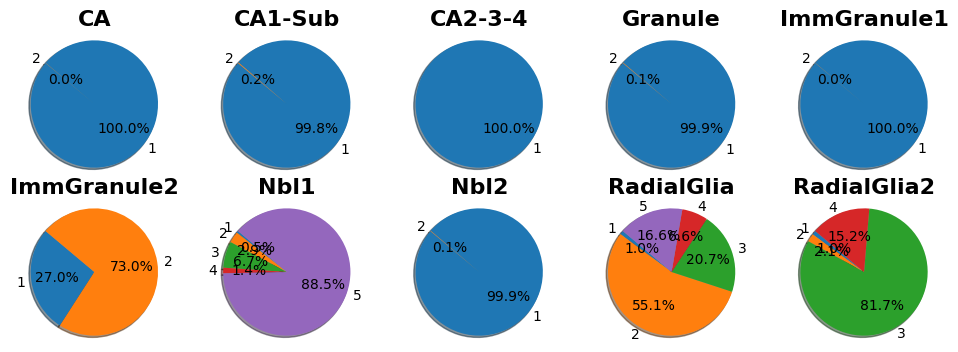

In [112]:
print(len(categories))
row,col = 2,5
fig, axs = plt.subplots(row, col,figsize = (12,4))
k = 0
for i in categories:
    print('')
    print(f'cluster number of {i}',len(set(TT[i])))
    for j in set(TT[i]):
        print(f'num of {j} type in {i}:',np.sum(TT[i] == j))
    axs[k//col,k%col].pie([np.sum(TT[i] == j) for j in set(TT[i])], labels=set(TT[i]), autopct='%1.1f%%', shadow=True, startangle=140)
    axs[k//col,k%col].axis('equal')  # 确保饼图是圆形的
    axs[k//col,k%col].set_title(f'{i}',fontsize=16,weight='bold')
    k+=1
# plt.title('Clustering of eigenvectors on different cell',fontsize=20,weight='bold')
plt.savefig(result_path+f'pie_eigenvector{t}.png')
plt.show()


plot the new vector

In [113]:
def plot3d(x1,x2,x3,color,color_bar_name='color_bar',save_name='3d.png'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
    cmap = plt.colormaps['Spectral']
    sc = ax.scatter(x1, x2, x3,  s=10, c=color,alpha=0.8,cmap=cmap)
    cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label(color_bar_name)
    plt.savefig(result_path+save_name)
    plt.show()

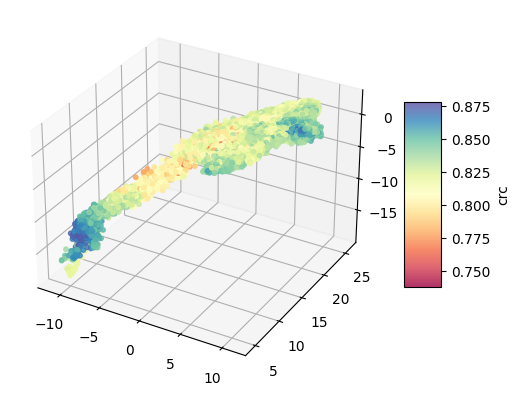

In [114]:
###CRC ON EMBEDDIGN
if L>2:
    max1,max2,max3 = np.argsort(np.mean(sigma_learned**2,axis=0))[-3:]
    plot3d(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],
       color=crc_smooth,color_bar_name='crc',save_name=f'cl on embedding{K}_{L}.png')

In [115]:
colors = [
    ('red', '#FF0000'),
    ('green', '#00FF00'),
    ('blue', '#0000FF'),
    ('black', '#000000'),
    ('lime', '#FFFFFF'),
    ('cyan', '#00FFFF'),
    ('magenta', '#FF00FF'),
    ('orange', '#FFA500'),
    ('purple', '#800080'),
    ('yellow', '#FFFF00'),
    ('gray', '#808080')
]

In [116]:
newvec={}
startvec={}
color_cl = {}
k=0
X = X.astype(np.float32)
for i in categories:
    newvec[i] ,startvec[i] = [],[]
    color_cl[i] = colors[k][0]
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        newvec[i].append(cell_i + 0.1*vec_j)
        startvec[i].append(cell_i)

In [117]:
color_cell = []
for i in range(len(X)):
    color_cell.append(color_cl[clusters[i]])

In [118]:
#3d
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # ax.scatter(x1, x2, x3,  s=10, c=color_label,alpha=0.8,cmap=plt.cm.jet)
# cmap = plt.colormaps['Spectral']
# ax.scatter(mu_learned[:,max1], mu_learned[:,max2], mu_learned[:,max3],c='grey',s=1,alpha=0.2)
# for i in categories:
#     k=0
#     for j in newvec[i]:
#         embed_j = encoder(torch.tensor(j.astype(np.float32)))
#         embed_j_mu = embed_j[0].detach().numpy()
#         print(i,embed_j)
#         ax.scatter(embed_j_mu[max1], embed_j_mu[max2], embed_j_mu[max3], c=color_cl[i], s=40,alpha=1,cmap=cmap,
#                    label = i if k==0 else None)
#         k+=1
# plt.legend(loc='upper left', fontsize=8)
# plt.savefig(result_path+'3d_eigenvector.png')
# plt.show()

In [119]:
####cluster内整体正负号调整
newvec={}
k=0
for i in categories:
    newvec[i]  = []
    k+=1
    cell_i = np.mean(X[clusters==i],axis=0)
    for j in set(TT[i]):
        vec_j = np.mean(eigenvec[i][TT[i]==j],axis=0)
        if i in ['Nbl2','ImmGranule2','CA','RadialGlia','RadialGlia2']:
            vec_j = -vec_j
        newvec[i].append(cell_i + 0.1*vec_j)
    newvec[i] = np.array(newvec[i])

In [120]:
import umap
trans = umap.UMAP(n_neighbors=20, random_state=42).fit(X)

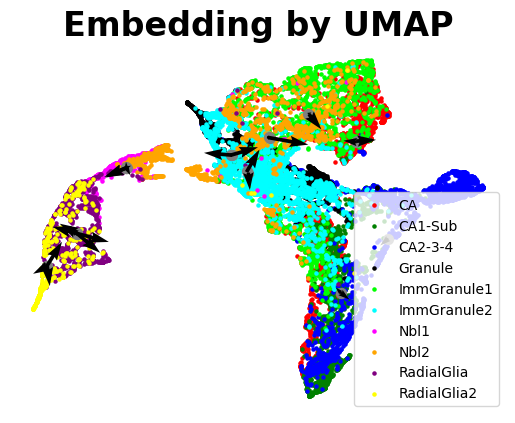

In [121]:
np.random.seed(42)
for i in categories:
    plt.scatter(trans.embedding_[clusters==i, 0], trans.embedding_[clusters==i, 1], s= 5,c = color_cl[i],
                cmap='Spectral',label=f'{i}')
for i in newvec:
    start_embedding = trans.transform(np.vstack(startvec[i]))
    test_embedding = trans.transform(np.vstack(newvec[i]))
    plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
    plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
               test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
               scale=1)
plt.title('Embedding by UMAP', fontsize=24,weight='bold')
plt.legend(loc='lower right')
plt.axis('off')
plt.savefig(result_path+'umap_eigenvector.png')
plt.show()

In [122]:
########machine learning for TSNE
#------use a simple neural network to study dmu/dt and dsigma/dt

model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

x_in=torch.tensor(X.astype(np.float32))
x_out=torch.tensor(np.vstack((X_plt,Y_plt)).T.astype(np.float32))
# Train the model
for epoch in range(300):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
    if epoch% 10 == 9:
        print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


9 tensor(63.9807, grad_fn=<MseLossBackward0>)
19 tensor(49.3881, grad_fn=<MseLossBackward0>)
29 tensor(38.0831, grad_fn=<MseLossBackward0>)
39 tensor(33.8361, grad_fn=<MseLossBackward0>)
49 tensor(31.2659, grad_fn=<MseLossBackward0>)
59 tensor(29.2513, grad_fn=<MseLossBackward0>)
69 tensor(27.7688, grad_fn=<MseLossBackward0>)
79 tensor(26.4560, grad_fn=<MseLossBackward0>)
89 tensor(25.2951, grad_fn=<MseLossBackward0>)
99 tensor(24.2668, grad_fn=<MseLossBackward0>)
109 tensor(23.3704, grad_fn=<MseLossBackward0>)
119 tensor(22.6157, grad_fn=<MseLossBackward0>)
129 tensor(21.9971, grad_fn=<MseLossBackward0>)
139 tensor(21.4811, grad_fn=<MseLossBackward0>)
149 tensor(21.0531, grad_fn=<MseLossBackward0>)
159 tensor(20.7038, grad_fn=<MseLossBackward0>)
169 tensor(20.4080, grad_fn=<MseLossBackward0>)
179 tensor(20.1503, grad_fn=<MseLossBackward0>)
189 tensor(19.9207, grad_fn=<MseLossBackward0>)
199 tensor(19.7119, grad_fn=<MseLossBackward0>)
209 tensor(19.5188, grad_fn=<MseLossBackward0>)
219

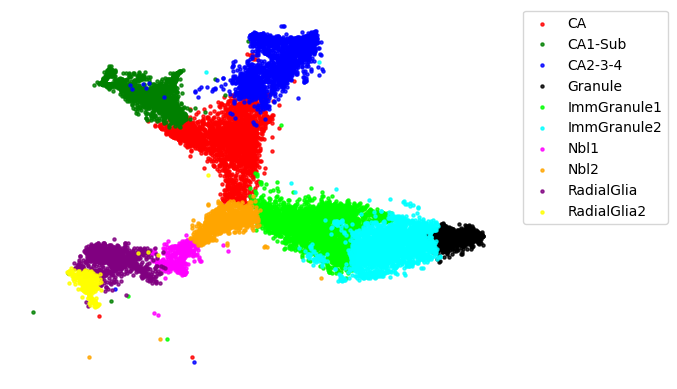

In [123]:
np.random.seed(42)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
                cmap='Spectral',label=f'{i}')
# for i in newvec:
#     start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
#     test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
#     #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
#     plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
#                test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
#                scale=0.3)
# plt.title('Embedding by TSNE', fontsize=24)
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
plt.axis('off')
plt.savefig(result_path+'TSNE_eigenvector.png',bbox_inches='tight')
plt.show()

In [124]:
len(TT['CA']),len(eigenvec['CA'])

(2298, 2298)

In [125]:
clusters_mine = []
ktime = {}
eigenvec_mine = {}
for k,i in enumerate(clusters):
    if i in ktime:
        ktime[i] = ktime[i]+1
    else:
        ktime[i] = 0
    clusters_mine.append(f'{i}_{TT[i][ktime[i]]}')
    if f'{i}_{TT[i][ktime[i]]}'  not in eigenvec_mine:
        eigenvec_mine[f'{i}_{TT[i][ktime[i]]}'] = []
    eigenvec_mine[f'{i}_{TT[i][ktime[i]]}'].append(eigenvec[i][ktime[i]])
clusters_mine = np.array(clusters_mine)

In [126]:
for i in eigenvec_mine:
    eigenvec_mine[i] = np.array(eigenvec_mine[i])

In [127]:
colors_hex = [
    "#FF5733", "#FFBD33", "#FFC300", "#DAFF33", "#33FF57", 
    "#33FFBD", "#33C1FF", "#337BFF", "#335BFF", "#5733FF", 
    "#BD33FF", "#FF33F6", "#FF33A1", "#FF335B", "#FF5733", 
    "#FF8D33", "#FF3333", "#FF6633", "#FF9933", "#FFFF33", 
    "#BFFF33", "#33FF8D", "#33FF99", "#33FFFF", "#3399FF", 
    "#3366FF", "#6633FF", "#9933FF", "#FF33C4", "#FF33A1", 
    "#FF5733", "#FF8D33"
]

# 转换为NumPy数组
colors_np = np.array(colors_hex)

# 打印结果
print(colors_np)

['#FF5733' '#FFBD33' '#FFC300' '#DAFF33' '#33FF57' '#33FFBD' '#33C1FF'
 '#337BFF' '#335BFF' '#5733FF' '#BD33FF' '#FF33F6' '#FF33A1' '#FF335B'
 '#FF5733' '#FF8D33' '#FF3333' '#FF6633' '#FF9933' '#FFFF33' '#BFFF33'
 '#33FF8D' '#33FF99' '#33FFFF' '#3399FF' '#3366FF' '#6633FF' '#9933FF'
 '#FF33C4' '#FF33A1' '#FF5733' '#FF8D33']


In [128]:
kk = 0
for i in set(clusters_mine):
    print(np.sum(clusters_mine==i))

    kk+=1
print(kk)

3
12
862
216
28
1
4
1661
6
1
371
173
8
317
1
567
2297
2129
1002
2459
10
69
575
2
59
1532
1
27


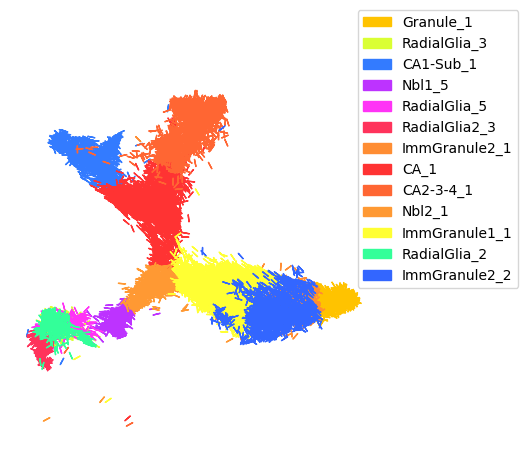

In [129]:
for k,i in enumerate(set(clusters_mine)):
    if np.sum(clusters_mine==i)<100:
        continue
    # start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    start_embedding = np.vstack((X_plt,Y_plt)).T[clusters_mine==i]
    test_embedding = model(torch.tensor(X[clusters_mine==i]+eigenvec_mine[i].astype(np.float32))).detach().numpy()
    if i in ['Nbl2','ImmGranule2','RadialGlia','RadialGlia2','Granule','CA']:
        test_embedding = model(torch.tensor(X[clusters_mine==i]-eigenvec_mine[i].astype(np.float32))).detach().numpy()
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        # drop = np.random.random()
        # if drop >0.1:
        #     continue
        # if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.01:
        #     continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])#/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(start_embedding[j,0],start_embedding[j,1],
                  (test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=colors_np[k],label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.legend(bbox_to_anchor=(1.4,0.4),loc='lower right')
plt.savefig(result_path+f'arrow_mine of {data_name}.png',dpi = 900)
plt.show()

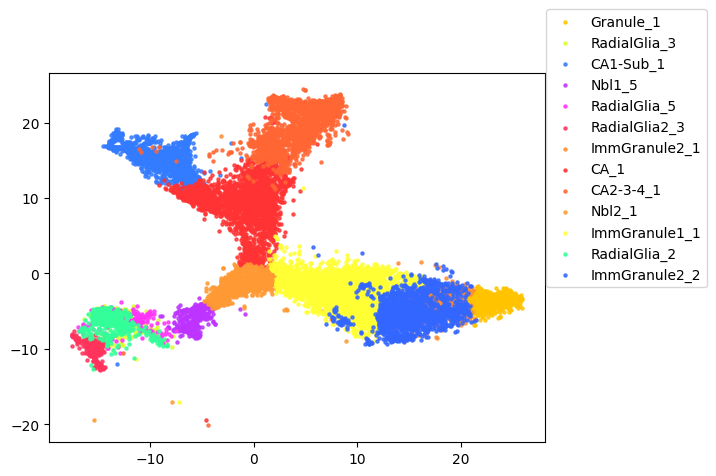

In [130]:
np.random.seed(42)
for k,i in enumerate(set(clusters_mine)):
    if np.sum(clusters_mine==i)<100:
        continue
    plt.scatter(X_plt[clusters_mine==i],Y_plt[clusters_mine==i], s= 5,c = colors_np[k],alpha=0.8,
                cmap='Spectral',label=f'{i}')
# for i in newvec:
#     start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
#     test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
#     #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
#     plt.quiver(start_embedding[:, 0], start_embedding[:, 1],
#                test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
#                scale=0.3)
# plt.title('Embedding by TSNE', fontsize=24)
plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
# plt.savefig(result_path+'TSNE_eigenvector.png',bbox_inches='tight')
plt.show()

In [131]:
adata.uns['leiden_colors']

array(['#023fa5', '#7d87b9', '#bec1d4', '#d6bcc0', '#bb7784', '#8e063b',
       '#4a6fe3', '#8595e1', '#b5bbe3', '#e6afb9', '#e07b91', '#d33f6a',
       '#11c638', '#8dd593', '#c6dec7', '#ead3c6', '#f0b98d', '#ef9708'],
      dtype=object)

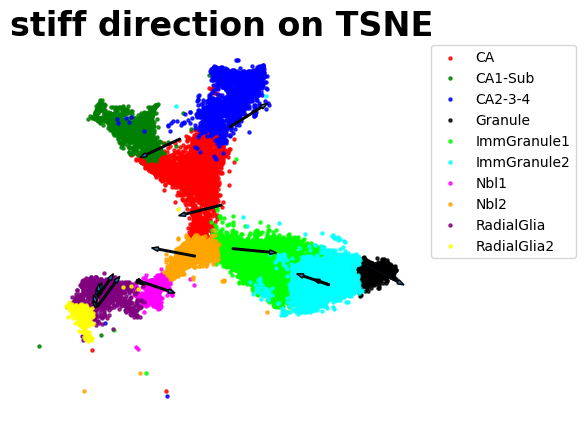

In [132]:
np.random.seed(42)
for i in categories:
    plt.scatter(X_plt[clusters==i],Y_plt[clusters==i], s= 5,c = color_cl[i],alpha=0.8,
                cmap='Spectral',label=f'{i}')
for i in newvec:
    start_embedding = model(torch.tensor(startvec[i])).detach().numpy()
    test_embedding = model(torch.tensor(newvec[i].astype(np.float32))).detach().numpy()
    for j in range(len(set(TT[i]))):
        if np.sum(TT[i]==list(set(TT[i]))[j])/len(TT[i])<0.01:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i]==list(set(TT[i]))[j])*len(TT[i])
    #plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s= 50, c='grey',cmap='Spectral')
        plt.arrow(start_embedding[j, 0], start_embedding[j, 1],
                (test_embedding[j, 0] - start_embedding[j, 0])/lenvecj*5,
                (test_embedding[j, 1] - start_embedding[j, 1])/lenvecj*5,width=0.2)
plt.title('stiff direction on TSNE', fontsize=24,weight='bold')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.legend(bbox_to_anchor=(1.4,0.4),loc='lower right')
# plt.savefig(result_path+'TSNE_eigenvector.png')
plt.show()

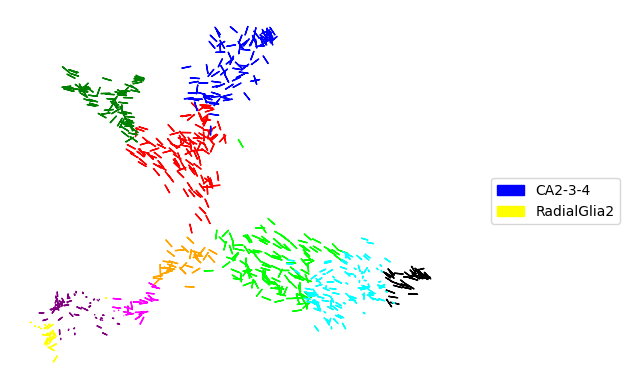

In [133]:
for i in categories:
    # start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    start_embedding = np.vstack((X_plt,Y_plt)).T[clusters==i]
    test_embedding = model(torch.tensor(X[clusters==i]+eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['Nbl2','ImmGranule2','RadialGlia','RadialGlia2','Granule','CA']:
        test_embedding = model(torch.tensor(X[clusters==i]-eigenvec[i].astype(np.float32))).detach().numpy()
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        drop = np.random.random()
        if drop >0.05:
            continue
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.01:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(start_embedding[j,0],start_embedding[j,1],
                  (test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
plt.gca().set_aspect('equal')
plt.axis('off')
plt.legend(bbox_to_anchor=(1.4,0.4),loc='lower right')
plt.savefig(result_path+f'arrow of {data_name}.png',dpi = 900)
plt.show()

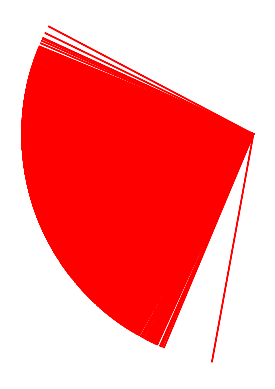

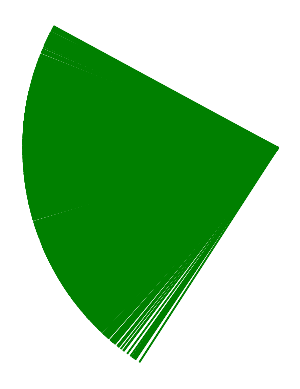

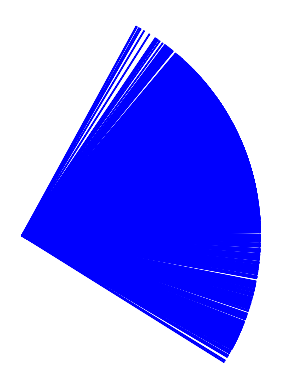

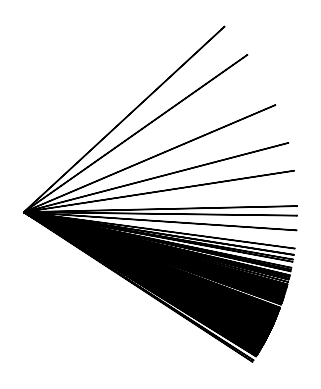

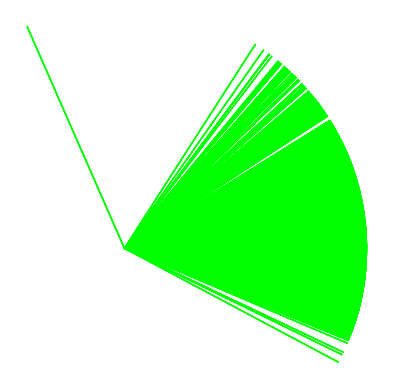

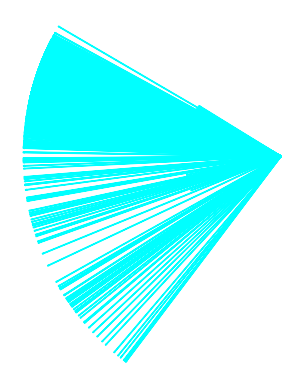

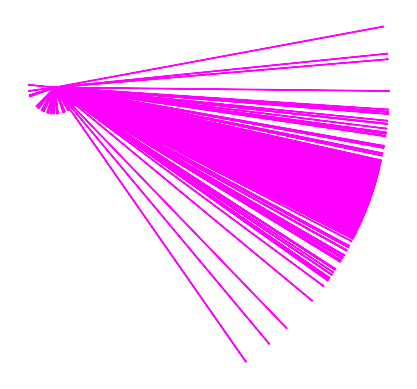

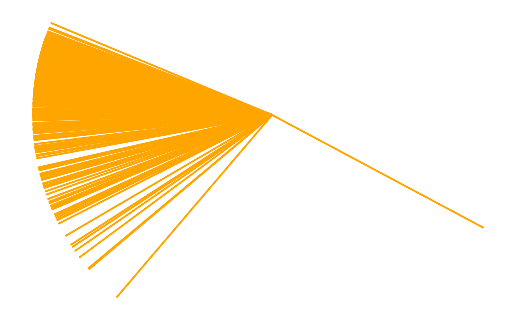

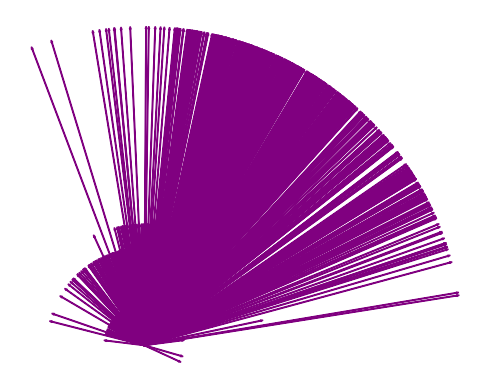

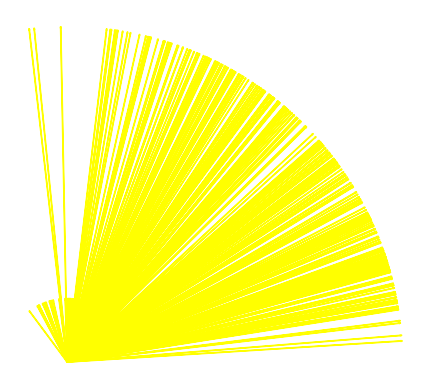

In [134]:
step_size = 1
for i in categories:
    start_embedding = model(torch.tensor(X[clusters==i])).detach().numpy()
    test_embedding = model(torch.tensor(X[clusters==i]+step_size*eigenvec[i].astype(np.float32))).detach().numpy()
    if i in ['CA','ImmGranule2','Nbl2','RadialGlia','RadialGlia2']:
        test_embedding = model(torch.tensor(X[clusters==i]-step_size*eigenvec[i].astype(np.float32))).detach().numpy()
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        if np.sum(TT[i] == TT[i][j])/len(TT[i]) < 0.05:
            continue
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(0,0,(test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
    plt.gca().set_aspect('equal')
    # plt.legend()
    plt.axis('off')
    plt.savefig(result_path+f'arrow of {i}.png')
    plt.show()

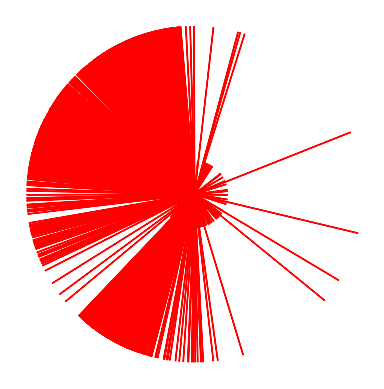

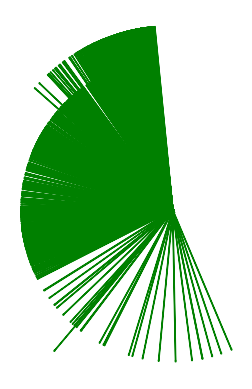

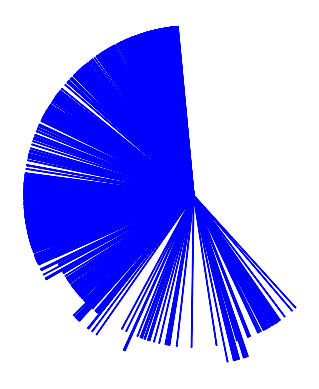

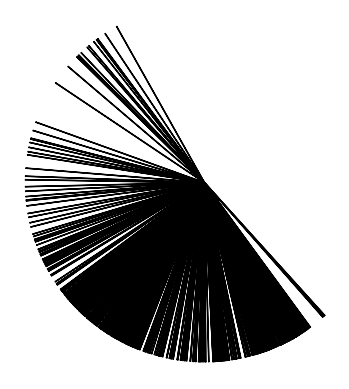

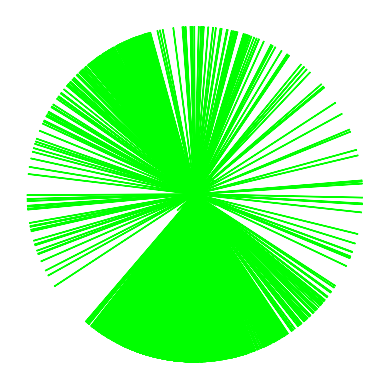

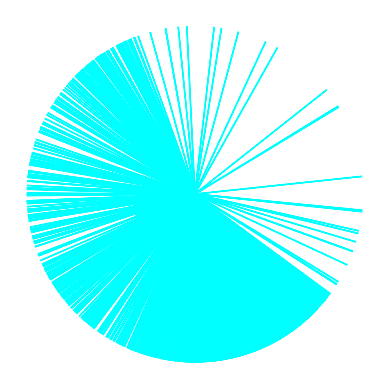

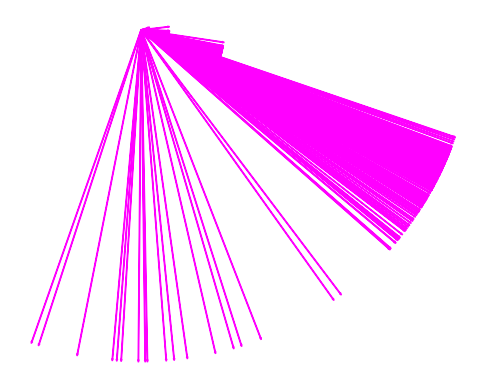

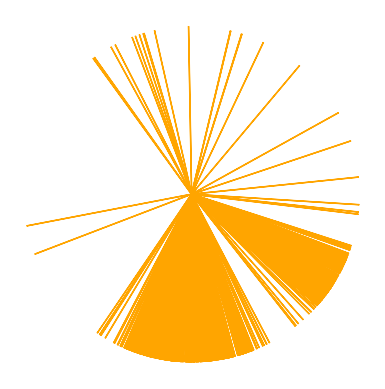

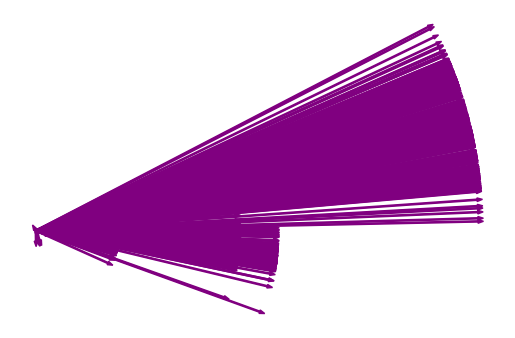

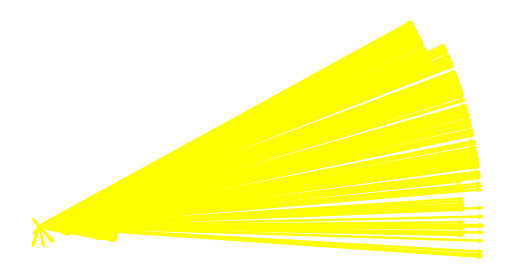

In [108]:
for i in categories:
    start_embedding = trans.transform(X[clusters==i])
    test_embedding = trans.transform(eigenvec[i])
    # plt.quiver(0, 0,
    #            test_embedding[:, 0] - start_embedding[:, 0],test_embedding[:, 1] - start_embedding[:, 1],
    #            scale=0.3)
    # plt.title('Embedding by TSNE', fontsize=24)
    # plt.legend(bbox_to_anchor=(1.34,0.4),loc='lower right')
    # plt.savefig(result_path+'TSNE_eigenvector.png')
    # plt.show()

    for j in range(len(start_embedding)):
        lenvecj = np.linalg.norm(test_embedding[j] - start_embedding[j])/np.sum(TT[i] == TT[i][j])*len(TT[i])
        plt.arrow(0,0,(test_embedding[j,0] - start_embedding[j,0])/lenvecj,
                  (test_embedding[j,1] - start_embedding[j,1])/lenvecj,
                  color=color_cl[i],label=f'{i}' if j==0 else None)
        
    #plt.title(i,fontsize=15,weight='bold')
    plt.gca().set_aspect('equal')
    # plt.legend()
    plt.axis('off')
    plt.show()

In [109]:
for i in categories:
    vec_corr = eigenvec[i]@eigenvec[i].T
    print(np.trace(vec_corr))

2298.0
1664.0
2129.0
863.0
2460.0
2099.0
419.0
1003.0
1043.0
388.0


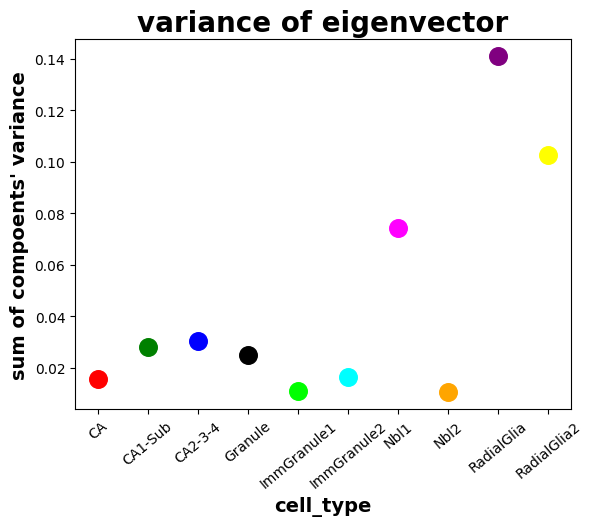

In [110]:
#variance of parameter velocity
k=0
for i in categories:
    # vec_corr = eigenvec[i]@eigenvec[i].T
    # plt.scatter(k,np.trace(vec_corr),label=i,s=10)
    plt.scatter(k,np.sum(np.var(eigenvec[i],axis=0)),label=i,s=160,c=color_cl[i])
    k+=1
plt.title('variance of eigenvector', fontsize=20,weight='bold')
plt.xticks(range(len(categories)),categories)
if np.sum([len(i) for i in categories])>50:
    plt.xticks(rotation=40)
# plt.legend()

plt.xlabel('cell_type',fontsize=14,weight='bold')
plt.ylabel("sum of compoents' variance",fontsize=14,weight='bold')
plt.savefig(result_path+f'variance of eigenvec',dpi=300, bbox_inches='tight')
plt.show()